In [1]:
import pandas as pd
import numpy as np
import os
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
from skimage import feature
from skimage import filters
from skimage import exposure
from skimage import img_as_float
from skimage import io

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Sampler

from datetime import datetime
from tqdm.notebook import tqdm as tqdm
from utils import mkdir, rmdir

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 10})
plt.style.use('ggplot')

In [113]:
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

In [112]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variable -Wno-unused-function -Wno-unused-result -Wno-strict-overflow -Wno-strict-aliasing -Wno-error=deprecated-declarations -Wno-stringop-overflow -Wno-error=pedantic -Wno-error=redundant-decls -Wno-error=old-style-cast -fdiagnostics-color=always -faligned-new -Wno-unused-but-set-variable -Wno-maybe-uninitialized -fno-math-errno -fno-trapping-

In [2]:
NUM_WORKERS = 24
CLASS_NUM = 43

IMG_SIZE = (64, 64)

MAX_ROTATION = 40

MIN_BRIGHTNESS = 0.4
MAX_BRIGHTNESS = 2.0

MIN_CONTRAST = 0.4
MAX_CONTRAST = 2.0

MIN_SATURATION = 0.4
MAX_SATURATION = 1.6

DISTORTION = 0.4
MAX_TRANSITION = 0.25

MIN_SCALE = 0.7
MAX_SCALE = 1.5

NOISE_STD = 0.2

In [3]:
def RandomNoise(tensor):
    std = np.random.uniform(0, NOISE_STD)
    return torch.clamp(tensor + torch.FloatTensor(tensor.size()).normal_(0, std), 0, 1)

In [4]:
my_transforms = {
    'default': T.Compose([
        T.Resize(IMG_SIZE),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor()
    ]),
    'train': T.Compose([
        T.RandomAffine(MAX_ROTATION, (MAX_TRANSITION, MAX_TRANSITION), (MIN_SCALE, MAX_SCALE)),
        T.RandomPerspective(DISTORTION),
        T.Resize(IMG_SIZE),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor(),
        T.Lambda(RandomNoise),
    ]),
    'test': T.Compose([
        T.Resize(IMG_SIZE),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor(),
    ])
}

In [5]:
train_path = 'dataset/train.csv'
test_path = 'dataset/test.csv'

image_path = 'dataset/images/'

In [6]:
def load_image(path, as_gray=True):
    return Image.fromarray(255 - io.imread(path, as_gray=as_gray))


torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


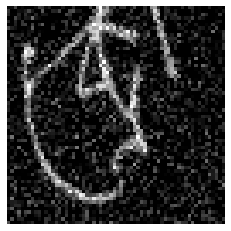

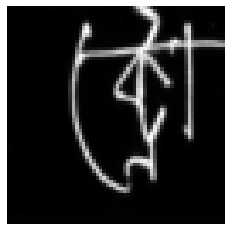

torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


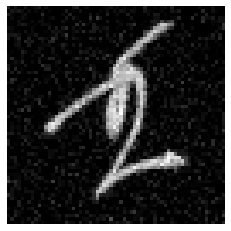

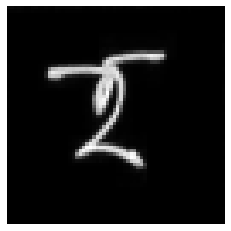

torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


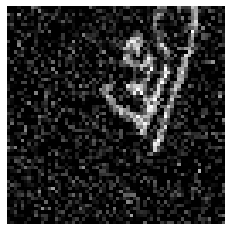

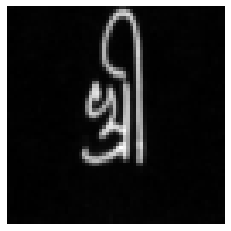

torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


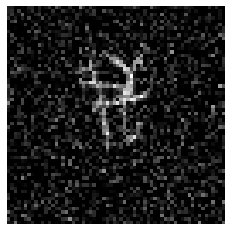

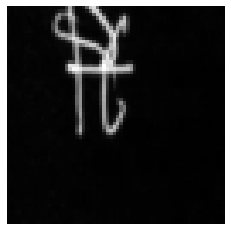

torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


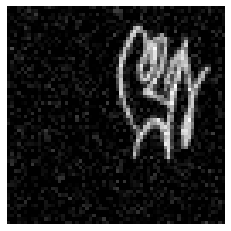

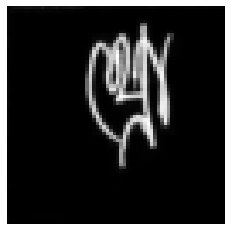

In [7]:
class BengaliDataset(Dataset):
    def __init__(self, path, image_path, 
                 target='classify',
                 transform=my_transforms['default'],
                 is_train=True, verbose=True):        
        self.is_train = is_train
        if not isinstance(transform, tuple):
            self.transform = (transform, transform)
        else:
            self.transform = transform
            
        assert target in {'reconstruct', 'classify'}
        self.target = target
        
        # reading labels
        df = pd.read_csv(path)
        self.image_ids = df.image_id.unique()
        self.length = len(self.image_ids)
        
        if self.is_train:
            self.labels = df[['grapheme_root','vowel_diacritic','consonant_diacritic']].values
        else:
            self.labels = [None] * self.length
        
        # reading images
        iterator = [os.path.join(image_path, f'{x}.png') for x in self.image_ids]
        with mp.Pool(16) as pool:
            iterator = pool.imap(load_image, iterator)
            if verbose:
                iterator = tqdm(iterator, total=len(self.image_ids))
            self.images = list(iterator)
        
    def __getitem__(self, idx):
        if self.target == 'reconstruct':            
            img = self.images[idx]
            img1 = self.transform[0](img)
            img2 = self.transform[1](img)
            return img1, img2
        
        return self.transform(self.images[idx]), self.labels[idx]
    
    def __len__(self):
        return self.length
    
Autoencoder_Train = BengaliDataset(train_path, image_path, target='reconstruct',
    transform=(my_transforms['train'], my_transforms['default']),
    is_train=True, verbose=True)
Autoencoder_Test = BengaliDataset(test_path, image_path, target='reconstruct',
    transform=(my_transforms['test'], my_transforms['default']),
    is_train=False, verbose=True)

for idx in range(5):
    img, target = Autoencoder_Train[idx]
    print(target.size(), type(target))
    print(img.size(), type(img))
    
    plt.imshow(TF.to_pil_image(img), cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(TF.to_pil_image(target), cmap='gray')
    plt.axis('off')
    plt.show()

# Variational Autoencoder

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(EncoderLayer, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1,inplace=True),
        )
        self.pool = nn.MaxPool2d(2)
        self.residuals = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        y = self.layers(x)
        y = self.pool(y)
        x = self.residuals(x)
        x = self.pool(x)
        return x + y

# x = torch.FloatTensor(size=(1,1,64,64))
# test_encoder_layer = EncoderLayer(1, 16)
# test_encoder_layer(x).size()

In [37]:
class DecoderLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DecoderLayer, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_ch),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_ch),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        )
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.residuals = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        y = self.conv_transpose(x)
        y = self.layers(y)
        x = self.upsample(x)
        x = self.residuals(x)
        return x + y
    
x = torch.FloatTensor(size=(16,128,4,4))
test_decoder_layer = DecoderLayer(128, 64)
print(test_decoder_layer)
test_decoder_layer(x).size()

DecoderLayer(
  (conv_transpose): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (layers): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (residuals): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
)


torch.Size([16, 64, 8, 8])

In [84]:
class VAE(nn.Module):
    def __init__(self, code_shape=32, filters=16, input_shape=(64,64)):
        super(VAE, self).__init__()  
        
        # params
        self.input_shape = input_shape
        self.hidden_shape = (input_shape[0] // 16, input_shape[1] // 16)
        self.code_shape = code_shape
        self.filters = filters
        
        # encoder convs
        self.input_layer = nn.BatchNorm2d(1)
        self.encoder_convs = nn.Sequential(
            EncoderLayer(1, filters), # 1x64x64 -> 16x32x32
            EncoderLayer(filters, filters * 2), # 16x32x32 -> 32x16x16
            EncoderLayer(filters * 2, filters * 4), # 32x16x16 -> 64x8x8
            EncoderLayer(filters * 4, filters * 8), # 64x8x8 -> 128x4x4
        )
        
        # encoder dense
        self.encoder_fcn = nn.Flatten()
        self.mean_layer = nn.Linear(self.filters * 8 * np.prod(self.hidden_shape), self.code_shape)
        self.logvar_layer = nn.Linear(self.filters * 8 * np.prod(self.hidden_shape), self.code_shape)
    
        # decoder convs
        self.decoder_fcn = nn.Linear(self.code_shape, self.filters * 8 * np.prod(self.hidden_shape))
        self.decoder_convs = nn.Sequential(
            DecoderLayer(filters * 8, filters * 4), # 128x4x4 -> 64x8x8
            DecoderLayer(filters * 4, filters * 2), # 64x8x8 -> 32x16x16
            DecoderLayer(filters * 2, filters), # 32x16x16 -> 16x32x32
            DecoderLayer(filters, filters), # 16x32x32 -> 16x64x64
        )
        self.sigmoid_layer = nn.Sequential(
            nn.BatchNorm2d(filters),
            nn.Conv2d(filters, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.input_layer(x)
        x = self.encoder_convs(x)
        x = self.encoder_fcn(x)
        
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    
    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + std * eps
    
    def decode(self, x):
        x = self.decoder_fcn(x)
        x = x.view(-1, self.filters * 8, *self.hidden_shape)
        x = self.decoder_convs(x)
        return self.sigmoid_layer(x)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrize(mean, logvar)
        return self.decode(z), mean, logvar
    
####

vae = VAE(64, filters=16, input_shape=(64,64))
# vae test

x = torch.FloatTensor(size=(16, 1, 64, 64))
print('Input:', x.size())

mean, logvar = vae.encode(x)
print('Encoded:', mean.size(), logvar.size())

decoded = vae.decode(mean)
print('Decoded:', decoded.size())

Input: torch.Size([16, 1, 64, 64])
Encoded: torch.Size([16, 64]) torch.Size([16, 64])
Decoded: torch.Size([16, 1, 64, 64])


# Train

In [104]:
num_epochs = 256
batch_size = 32

In [105]:
train_loader = DataLoader(Autoencoder_Train, batch_size=batch_size, shuffle=True,
    num_workers=12, drop_last=True)
test_laoder = DataLoader(Autoencoder_Train, batch_size=16, shuffle=True)
print('Train len:', len(train_loader))

Train len: 6276


In [106]:
batch_per_epoch = len(train_loader)

### Initializing

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [108]:
net = VAE(64, filters=16, input_shape=(64,64))
net = net.to(device)

In [109]:
optimizer = optim.Adam(net.parameters())

In [114]:
def loss_function(x, x_gt, mean, logvar):
    bce = nn.BCELoss(reduction='sum')(x.view(-1, 64*64), x_gt.view(-1, 64*64))
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return bce, kld

In [116]:
pbar = tqdm(total=num_epochs * batch_per_epoch)

for epoch in range(num_epochs):
    next_epoch = batch_per_epoch * (epoch + 1)
    
    net.train()
    for X_batch, Xgt_batch in train_loader:
        X_batch.to(device)
        Xgt_batch.to(device)
        
        optimizer.zero_grad()
        
        Xpred_batch, mean, logvar = net(X_batch)
        bce, kld = loss_function(Xpred_batch, Xgt_batch, mean, logvar)
        loss = bce + kld
        loss.backward()
        
        optimizer.step()
        pbar.set_description(
            f"[E{epoch:04d}, {next_epoch}] loss: \
            {loss.item():10.5f} = {bce.item():10.5f} + {kld.item():10.5f}")
        pbar.update(1)
    
    print(f"[Epoch{epoch:4d}] finished")

KeyboardInterrupt: 